<a href="https://colab.research.google.com/github/RandomSparrow/skills-copilot-codespaces-vscode/blob/main/Jellyfish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Libraries

In [1]:
#Paths and data
import zipfile
import os
from pathlib import Path
import json
import shutil

#Images and metrics
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score

#Pytorch workflow
from torchvision import transforms, models, datasets
from torchvision.transforms import v2
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.modules.linear import Linear
from torch.nn.modules import MaxPool2d
import torch

!pip install torchinfo
from torchinfo import summary



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.8 MB/s eta 0:00:00


#Importing data

In [2]:
#Creating paths
os.environ['KAGGLE_CONFIG_DIR']='/content'
MODEL_PATH = Path("Dataset")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / 'Jellyfish'

In [3]:
#Creating kaggle token
path={"username":"marcelwolfram","key":"c0302a9059596064b9b34c7ef52eab0b"}
s=json.dumps(path)

with open('/content/kaggle.json', 'w') as f:
  f.write(s)

In [4]:
#Importing data
!kaggle datasets download -d anshtanwar/jellyfish-types

 98% 25.0M/25.5M [00:02<00:00, 19.6MB/s]
100% 25.5M/25.5M [00:02<00:00, 11.9MB/s]


In [5]:
#Unpacking data
with zipfile.ZipFile('/content/jellyfish-types.zip','r') as zip_ref:
  zip_ref.extractall(MODEL_SAVE_PATH)

In [6]:
#Remove .zip file
os.remove('/content/jellyfish-types.zip')

In [7]:
#Remove unnecessary files
shutil.rmtree('/content/Dataset/Jellyfish/Train_Test_Valid', ignore_errors=True)

#Creating datasets


In [8]:
#Dataset Path
MODEL_SAVE_PATH

PosixPath('Dataset/Jellyfish')

In [9]:
#Dataset transformation

trans =v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
#Creating datasets folders
Data_folder = datasets.ImageFolder(root=MODEL_SAVE_PATH, # target folder of images
                                 transform=trans, #Data transformation
                                 target_transform=None) # transforms to perform on labels (if necessary)

Oryginal = datasets.ImageFolder(root=MODEL_SAVE_PATH,
                                 transform=v2.ToTensor(),
                                 target_transform=None)

img_train, img_test = train_test_split(Data_folder, test_size=0.2,random_state=42)
img_train_org, img_test_org = train_test_split(Oryginal, test_size=0.2,random_state=42)

In [11]:
#Data classes dictionary
Data_folder.class_to_idx

{'Moon_jellyfish': 0,
 'barrel_jellyfish': 1,
 'blue_jellyfish': 2,
 'compass_jellyfish': 3,
 'lions_mane_jellyfish': 4,
 'mauve_stinger_jellyfish': 5}

In [12]:
#Data classes list
classes=Data_folder.classes
classes

['Moon_jellyfish',
 'barrel_jellyfish',
 'blue_jellyfish',
 'compass_jellyfish',
 'lions_mane_jellyfish',
 'mauve_stinger_jellyfish']

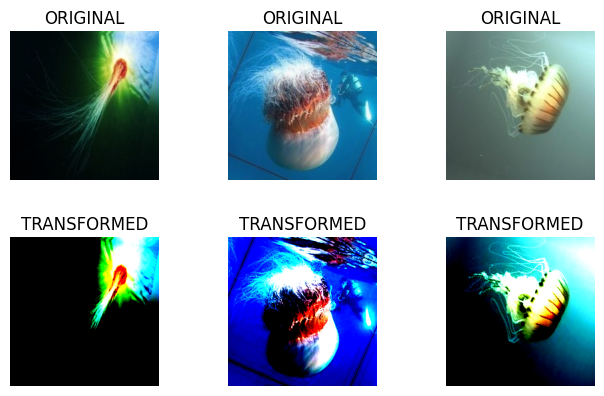

<Figure size 1200x1200 with 0 Axes>

In [13]:
#Data visualization

def visualization(transformed, original):
  for i in range(3):
    img_index=torch.randint(0,len(transformed), size=[1]) #Random index generator

    img_trans, class_trans = transformed[img_index.item()]
    img_original, class_original = original[img_index.item()]

    plt.subplot(2,3,i+1)
    plt.imshow(torch.permute(img_original, (1,2,0)))
    plt.title('ORIGINAL')
    plt.axis(False)
    plt.tight_layout(w_pad=5, pad=2)

    plt.subplot(2,3,i+4)
    plt.imshow(torch.permute(img_trans, (1,2,0)))
    plt.title('TRANSFORMED')
    plt.axis(False)
    plt.tight_layout(w_pad=5, pad=2)



  plt.figure(figsize=(12, 12))
  plt.show()

visualization(img_train, img_train_org)

In [14]:
#Creating DataLoaders

train_dataloader=DataLoader(dataset=img_train,
                            batch_size=16,
                            shuffle=True)

test_dataloader=DataLoader(dataset=img_test,
                            batch_size=16,
                            shuffle=False) #It is not neccessery to shuffle training data, because it hasn't any inpact on evaluation process


#Create model

In [15]:
#Model settings

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4

In [16]:
#TinyVGG model

class CNN_Jellyfish(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.CNNblock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.CNNblock2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.outputlayer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
            )
    def forward(self, x):
        return self.outputlayer(self.CNNblock2(self.CNNblock1(x)))

In [17]:
torch.manual_seed(42)

model1=CNN_Jellyfish(3,32,6).to(device)

In [18]:
#Transfer learning model
torch.manual_seed(42)

model2 = models.efficientnet_v2_s(weights='DEFAULT')
model2.classifier = torch.nn.Linear(in_features=1280,
                    out_features=6, # same number of output units as our number of classes
                    bias=True)
model2=model2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:02<00:00, 36.4MB/s]


In [19]:
#Insights about created models

#First model
summary(model=model1, input_size=[1,3,224,224])


Layer (type:depth-idx)                   Output Shape              Param #
CNN_Jellyfish                            [1, 6]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 32, 224, 224]         9,248
│    └─ReLU: 2-4                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-7                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-9                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 32, 56, 56]           --
├─Seq

In [20]:
#Second model
summary(model=model2, input_size=[1,3,224,224])


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 6]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         5,232
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                         

#Training and evaluation process

In [21]:
def training_loop(model, epochs, lr, Save_path):

  #Loss function
  loss_fn = nn.CrossEntropyLoss()

  #Optimizer
  optimizer=torch.optim.AdamW(model.parameters(), lr=lr)

  train=[]
  test=[]
  accuracy=[]
  epoch_list=[]
  best_epoch=[]

  start_time = timer()
  # Create training and testing loop
  for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}\n-------")
      ### Training
      train_loss = 0

      for batch, (X, y) in enumerate(train_dataloader):
          model.train()
          X,y= X.to(device), y.to(device)
          # 3. Optimizer zero grad
          optimizer.zero_grad()

          # 1. Forward pass
          y_pred = model(X)

          # 2. Loss function
          loss = loss_fn(y_pred, y)
          train_loss += loss



          # 4. Loss backward
          loss.backward()

          # 5. Optimizer step
          optimizer.step()

          if batch % 16 == 0:
              print(f"Samples {batch * len(X)}/{len(train_dataloader.dataset)}")


      train_loss /= len(train_dataloader)
      train.append(train_loss)

      ### Testing
      test_loss, test_acc = 0, 0

      model.eval()
      with torch.inference_mode():
          for A, b in test_dataloader:
              A,b= A.to(device), b.to(device)

              # 1. Forward pass
              test_pred = model(A)

              # 2. Loss fuction
              test_loss += loss_fn(test_pred, b)

              # 3. Accuracy score
              test_acc += accuracy_score(b.cpu(), (torch.softmax(test_pred, dim=1).argmax(dim=1)).cpu())

          test_loss /= len(test_dataloader)
          test.append(test_loss)

          test_acc /= len(test_dataloader)
          accuracy.append(test_acc)
          epoch_list.append(epoch)

      print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")

      if test_acc == max(accuracy) and test_loss == min(test):
        torch.save(model.state_dict(), f=Save_path)
        print("Model's parameters saved\n")
        best_epoch.append(epoch)


  end_time = timer()
  print(f"""
  [INFO] Total training time: {end_time-start_time:.3f} seconds
         The Best predictions were made in epoch number {max(best_epoch)}:
            - Test loss: {test[max(best_epoch)]:.5f}
            - Accuracy: {accuracy[max(best_epoch)]*100:.2f}%""")

  return train, test, accuracy, epoch_list

In [22]:
#Creating model's saving path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [23]:
#Epochs
epochs=10

#Learning rate
lr=0.0001

In [24]:
#Saving path
SAVE_PATH1 = MODEL_PATH / 'model1_best'

train_model1, test_model1, accuracy_model1, epoch_list_model1 = training_loop(model1, epochs, lr, SAVE_PATH1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 1.73947 | Test loss: 1.59583, Test acc: 30.21%

Model's parameters saved

Epoch: 1
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 1.41677 | Test loss: 1.37000, Test acc: 44.79%

Model's parameters saved

Epoch: 2
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 1.11383 | Test loss: 1.25834, Test acc: 43.75%

Epoch: 3
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.93727 | Test loss: 1.16188, Test acc: 54.69%

Model's parameters saved

Epoch: 4
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.80222 | Test loss: 1.20013, Test acc: 56.25%

Epoch: 5
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.71572 | Test loss: 1.11278, Test acc: 61.46%

Model's parameters saved

Epoch: 6
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.60016 | Test loss: 1.13059, Test acc: 60.42%

Epoch: 7
-------
Samples 0/7

In [25]:
#Saving path
SAVE_PATH2 = MODEL_PATH / 'model2_best'

train_model2, test_model2, accuracy_model2, epoch_list_model2  = training_loop(model2, epochs, lr, SAVE_PATH2)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 1.24527 | Test loss: 0.51753, Test acc: 93.23%

Model's parameters saved

Epoch: 1
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.27720 | Test loss: 0.10056, Test acc: 98.44%

Model's parameters saved

Epoch: 2
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.08417 | Test loss: 0.03130, Test acc: 100.00%

Model's parameters saved

Epoch: 3
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.06227 | Test loss: 0.03905, Test acc: 100.00%

Epoch: 4
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.04007 | Test loss: 0.04338, Test acc: 98.44%

Epoch: 5
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.02213 | Test loss: 0.00764, Test acc: 100.00%

Model's parameters saved

Epoch: 6
-------
Samples 0/720
Samples 256/720
Samples 512/720

Train loss: 0.03059 | Test loss: 0.00590, Test acc: 100.00%

Model's parameters saved

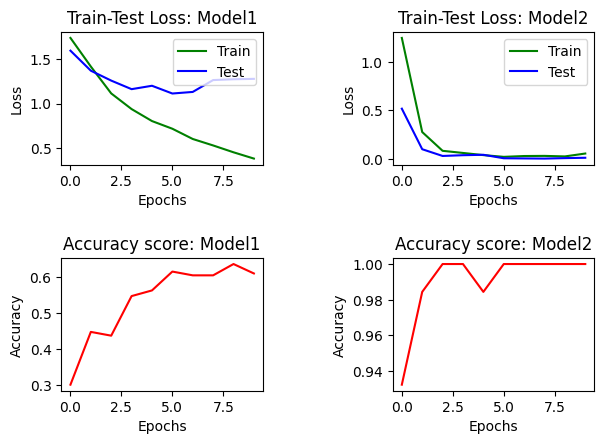

In [26]:
#Comparison train loss, test loss and accuracy in model 1 and 2
val=[(train_model1, test_model1, accuracy_model1, epoch_list_model1),
     (train_model2, test_model2, accuracy_model2, epoch_list_model2)]

for x in range(len(val)):

  plt.subplot(2,2,x+1)
  plt.title(f'Train-Test Loss: Model{x+1}')
  plt.plot(val[x][3], torch.tensor(val[x][0]), c="green", label='Train')
  plt.plot(val[x][3], torch.tensor(val[x][1]), c="blue", label='Test')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.tight_layout(w_pad=5, pad=2)

  plt.subplot(2,2,x+3)
  plt.title(f'Accuracy score: Model{x+1}')
  plt.plot(val[x][3], torch.tensor(val[x][2]), c="red")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.tight_layout(w_pad=5, pad=2)

plt.show()

In [27]:
#Loading best parameters to our models
def load(model, path):
  model.load_state_dict(torch.load(path))
  y_predicted=[]
  model.eval()
  with torch.inference_mode():
      for A, b in test_dataloader:
          A,b= A.to(device), b.to(device)

          test_pred = model(A)
          y_predicted.append((torch.softmax(test_pred, dim=1).argmax(dim=1)).cpu())

  return y_predicted

y_predicted_model1=load(model1, SAVE_PATH1)
y_predicted_model2=load(model2, SAVE_PATH2)


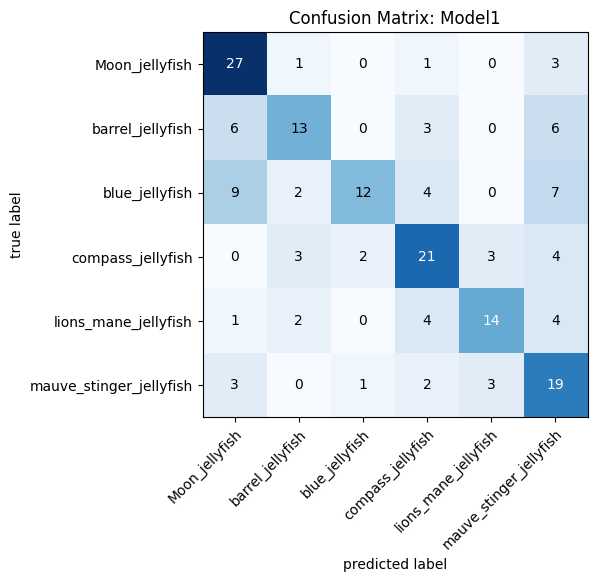

In [28]:
#Creating cofusion matrix
img_train_target, img_test_target = train_test_split(Data_folder.targets, test_size=0.2,random_state=42)

def confusion_matrix(pred,a):
  matrix=ConfusionMatrix(num_classes=len(classes), task='multiclass')
  matrix_tensor=matrix(preds=torch.cat(pred), target=torch.tensor(img_test_target))

  plot_mat= plot_confusion_matrix(
    conf_mat=matrix_tensor.numpy(),
    class_names=classes,
    figsize=(5,5)
  )
  plt.title(f'Confusion Matrix: Model{a}')
  plt.show()

#Confusion matrix to model1
confusion_matrix(y_predicted_model1, 1)


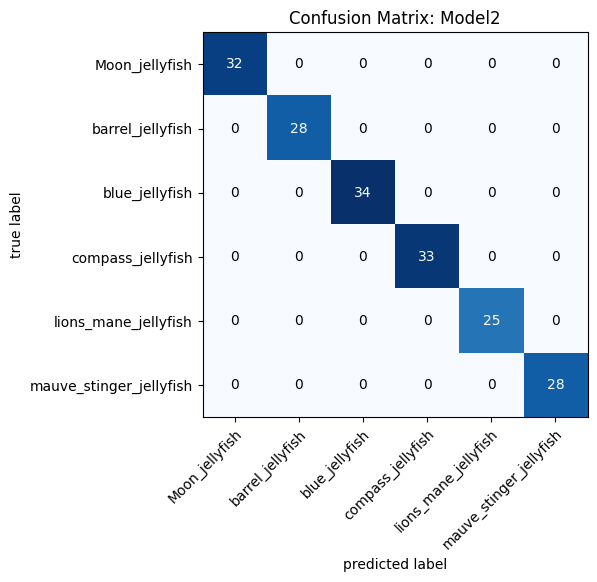

In [29]:
#Confusion matrix to model2
confusion_matrix(y_predicted_model2, 2)
